# AutoExpo 2016 Analysis


## First step :   Collecting tweets with help of Twitter Streaming API

In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import json
import string
import re
from pylab import *
import operator 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


### Total Number of tweets and sample tweets

In [2]:
tweets = []
f = open('tweets.json', 'r',encoding='utf-8')
for line in f:
    try:
        tweet = json.loads(line)
        tweets.append(tweet)
    except:
        continue
        
print('Sample Tweet in JSON Format : \n')
print(json.dumps(tweets[1:2],indent=2))

Sample Tweet in JSON Format : 

[
  {
    "created_at": "Fri Feb 05 13:00:13 +0000 2016",
    "truncated": false,
    "in_reply_to_user_id": null,
    "user": {
      "created_at": "Sat Oct 01 12:15:40 +0000 2011",
      "notifications": null,
      "description": "A Student | Childish Teenager | Social Media Influencer | Contests Freak | Gadget Lovers | @imVkohli Addict | Love Cricket | Proud Indian |",
      "profile_link_color": "3B94D9",
      "verified": false,
      "favourites_count": 23581,
      "following": null,
      "follow_request_sent": null,
      "id_str": "383179849",
      "profile_text_color": "3C3940",
      "location": "Hyderabad, India",
      "friends_count": 3485,
      "statuses_count": 77384,
      "profile_image_url": "http://pbs.twimg.com/profile_images/694233257538269185/4xKWpeVf_normal.jpg",
      "profile_sidebar_fill_color": "95E8EC",
      "default_profile": false,
      "profile_background_color": "FFCC4D",
      "followers_count": 108975,
      "prof

In [3]:
print('Total Numbe of tweets of tweets:', len(tweets))
print('\n')
print('Example tweets : \n')
for tweet in tweets[:5]:
    print(tweet['text'])
    print('---------------------------------------------------------------------------------')

Total Numbe of tweets of tweets: 24087


Example tweets : 

RT @PressPlayTVapp: Get all action from @AutoExpo2016  on #PressPlay! Download the App Now: https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht…
---------------------------------------------------------------------------------
Now GO-cross Concept has added a sense of fun &amp; adventure to the line-up at the #DatsunPavilion #AETMS2016  https://t.co/q2m8ZPbkn7
---------------------------------------------------------------------------------
RT @AutoExpo2016: It's raining celebrities at #AETMS16! #Spotted the dashing @AnilKapoor at the @Maruti_Corp pavilion @NexaExperience https…
---------------------------------------------------------------------------------
The Honda BR-V at the #AutoExpo2016 , how does it look ? https://t.co/oICRRqZpVY
---------------------------------------------------------------------------------
RT @moneycontrolcom: BMW launches X5 xDrive30d M Sport priced at Rs 75.90 lakh https://t.co/iOLXulKNUq @odmag @BM

## Fetching Datasets

In [43]:
 #Timeseries dataset for tweets generated in every 5 minutes.
timeseries_df = pd.read_csv('timeseries_dataset.csv')
#Frequency Dataset for frequency of Hashtags,Mentions,Screen names and Languages.
freq_df = pd.read_csv('frequency_dataset.csv',encoding = "ISO-8859-1") 
#Expo Dataset for tweets generated.
tweet_df = pd.read_csv('expoDataset.csv',encoding = "ISO-8859-1")

## Dataset Samples

In [44]:
timeseries_df.head()

,Time,total_freq,BMW,DATSUN,FORD,HONDA,JAGUAR,MARUTI,NISSAN,TATA,TOYOTA
0,05-02-2016 13:00,67,11,49,3,1,0,5,0,3,1
1,05-02-2016 13:05,76,5,35,7,13,3,1,0,2,2
2,05-02-2016 13:10,97,15,55,9,0,0,3,5,2,4
3,05-02-2016 13:15,47,8,23,10,1,1,1,0,2,2
4,05-02-2016 13:20,71,4,18,5,2,2,4,0,9,0


In [6]:
freq_df.head()

,Hashtags,Hashtag_count,Mentions,Mention_count,TermsOnly,Term_count,Language,Language_count,ScreenName,screenname_count,Places,places_count
0,#AutoExpo2016,7190,@AutoExpo2016,5164,Expo,9452,English,20937,JLRIndia,317,New Delhi,4687
1,#AETMS16,1764,@Nissan_India,1364,Auto,9235,Indonesian,532,TenNewsDotIn,143,Chennai,2571
2,#NissanPavilion,1714,@FordIndia,1007,2016,6334,Hindi,469,AutoExpo2016,126,Pacific Time (US & Canada),2266
3,#AETMS2016,1047,@honda2wheelerin,1001,India,1727,Tagalog,354,JBMAuto,99,Mumbai,1321
4,#ToyotaAtAutoExpo,889,@Toyota_India,880,new,1087,Spanish,235,Rajendra9Prasad,94,Hawaii,511


In [7]:
tweet_df.head()

,created_at,screen_name,text,target
0,Fri Feb 05 13:00:05 +0000 2016,elango2105,RT @PressPlayTVapp: Get all action from @AutoE...,Advertisement
1,Fri Feb 05 13:00:13 +0000 2016,sujaykoner,Now GO-cross Concept has added a sense of fun ...,Technology
2,Fri Feb 05 13:00:17 +0000 2016,NexaExperience,RT @AutoExpo2016: It's raining celebrities at ...,Entertainment
3,Fri Feb 05 13:00:18 +0000 2016,TheQuint,"The Honda BR-V at the #AutoExpo2016 , how does...",Automobile
4,Fri Feb 05 13:00:20 +0000 2016,diwamishra,RT @moneycontrolcom: BMW launches X5 xDrive30d...,Business


# Text Preprocessing

### 1. In this part collected tweets are preprocessed i.e Tokenizing the text.

In [17]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^\x00-\x7F]+',#unicode
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    mess =  re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', s)
    return tokens_re.findall(mess)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens


 
tweet = "RT @PressPlayTVapp: Get all action from @AutoExpo2016  on #PressPlay! Download the App Now: https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht…"

print('Tweet after preprocessing : \n')
print(preprocess(tweet))


Tweet after preprocessing : 

['RT', '@PressPlayTVapp', ':', 'Get', 'all', 'action', 'from', '@AutoExpo2016', 'on', '#PressPlay', '!', 'Download', 'the', 'App', 'Now', ':', '#automobile', '#AETMS16', 'ht', '…']


### 2. Removing Stopwords , Hashtags and Mentions

In [27]:
import nltk
from nltk.corpus import stopwords
import string
punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', 
               '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

stop = stopwords.words('english') #removing stopwords
hashtags = [i for i in freq_df['Hashtags'] if i != None] #removing hashtags
mentions = [i for i in freq_df['Mentions'] if i != None] #removing mentions
#stop contains all the stopwords
stop += punctuation + ['RT', 'via','#AETMS2016','#AutoExpo2016','amp','The','\xa0','…','https','\x85']
#clean is list consisting stopwords along with hashtags and mentions
clean = stop + hashtags + mentions

In [28]:
#preprocess function
def text_preprocess(message): 
    return [term for term in preprocess(str(message)) if term not in clean]

tweet = "RT @bmwindia: The young generation loves them too! #FutureOfLuxury #AutoExpo2016 "
after_stop = [term for term in text_preprocess(tweet) if term not in clean]
print('Tweets before preprocessing : \n')
print(tweet)
print('\nTweets after preprocessing : \n')
print(' '.join(after_stop))


Tweets before preprocessing : 

RT @bmwindia: The young generation loves them too! #FutureOfLuxury #AutoExpo2016 

Tweets after preprocessing : 

young generation loves


## Term Frequency

### Calculating frequency of Hastags,Mentions,Terms used and Language

In [20]:
fname = 'tweets.json' # Loading tweets file
with open(fname, 'r') as f:
    hashtag = Counter()
    mention = Counter()
    termOnly = Counter()
    count_all = Counter()
    lang = []
    scrname = []
    places = []
    
    for line in f:
        try:
            #Loading tweet from tweets files
            tweet = json.loads(line)
            
            # creating list for all terms used, hashtags , terms other than hashtags and mentions , mentions , languages used
            # and screen names
            terms_stop = [term for term in preprocess(tweet['text']) if term not in stop]
            
            terms_hash = [term for term in preprocess(tweet['text']) if term.startswith('#') and term != '#']
            
            terms_only = [term for term in preprocess(tweet['text']) if term not in stop and not term.startswith(('#', '@'))] 
            
            terms_mention = [term for term in preprocess(tweet['text']) if term.startswith('@') and term != '@']
            
            if tweet['user']['time_zone'] != None:
                places.append(tweet['user']['time_zone'])
                
            if tweet['lang'] != 'und':
                lang.append(tweet['lang'])
                
            if tweet['user']['screen_name']:
                scrname.append(tweet['user']['screen_name'])
                
            
            #simultaneous update of the count for each tweet fetched from the tweets file
            
            screen_name_count = Counter(scrname)
            
            lang_count = Counter(lang)
            
            places_count = Counter(places)

            count_all.update(terms_stop)
            
            hashtag.update(terms_hash)
            
            mention.update(terms_mention)
            
            termOnly.update(terms_only)
            
            
        except ValueError:
            continue


# Creating dataframe each of the terms calculated above

hashtag_df = DataFrame(hashtag.most_common())
hashtag_df.columns = ['Hashtags','Hashtag_count']

mention_df = DataFrame(mention.most_common())
mention_df.columns = ['Mentions','Mention_count']

termOnly_df = DataFrame(termOnly.most_common())
termOnly_df.columns = ['TermsOnly','Term_count']

lang_df = DataFrame(lang_count.most_common())
lang_df.columns = ['Language','Language_count']

screen_name_df = DataFrame(screen_name_count.most_common())
screen_name_df.columns = ['ScreenName','Count']

places_df = DataFrame(places_count.most_common())
places_df.columns = ['Places','Count']


### Dataframes Samples

In [21]:
hashtag_df.head()

,Hashtags,Hashtag_count
0,#AutoExpo2016,7190
1,#AETMS16,1764
2,#NissanPavilion,1714
3,#AETMS2016,1047
4,#ToyotaAtAutoExpo,889


In [22]:
mention_df.head()

,Mentions,Mention_count
0,@AutoExpo2016,5164
1,@Nissan_India,1364
2,@FordIndia,1007
3,@honda2wheelerin,1001
4,@Toyota_India,880


In [23]:
termOnly_df.head()

,TermsOnly,Term_count
0,Expo,9452
1,Auto,9235
2,2016,6334
3,India,1727
4,new,1087


In [24]:
#mapping fullnames of languages to their keys

lang_map  ={'ar':'Arabic','bg':'Bulgarian','bn':'Bengali','cs':'czech','cy':'Welsh','da':'Danish','de':'German','el':'Greek',
            'en':'English','es':'Spanish','et':'Estonian','fi':'Finish','fr':'French','gu':'Gujrati','hi':'Hindi','ht':'Haitian Creole',
           'in':'Indonesian','is':'icelandic','it':'Italian','ja':'Japenese','kn':'Kannada','lt': 'Lithuanian','lv': 'Latvian',
            'ml': 'Malayalam','mr': 'Marathi','ne': 'Nepali','nl': 'Dutch','no': 'Norwegian','pa': 'Punjabi','pl': 'Polish',
            'pt': 'Portuguese','ro': 'Romanian','ru': 'Russian','si': 'Sinhalese','sl': 'Slovenian','sv': 'Swedish','ta': 'Tamil',
            'te': 'Telugu','tl': 'Tagalog','tr': 'Turkish'}
lang_df['Language'] = lang_df['Language'].map(lang_map)
lang_df.head()

,Language,Language_count
0,English,20937
1,Indonesian,532
2,Hindi,469
3,Tagalog,354
4,Spanish,235


In [25]:
screen_name_df.head()

,ScreenName,Count
0,JLRIndia,317
1,TenNewsDotIn,143
2,AutoExpo2016,126
3,JBMAuto,99
4,Rajendra9Prasad,94


In [26]:
places_df.head()

,Places,Count
0,New Delhi,4687
1,Chennai,2571
2,Pacific Time (US & Canada),2266
3,Mumbai,1321
4,Hawaii,511


In [71]:
#Concatenating each dataframe into single frequency dataframe and saving it in CSV format
#freq_df = pd.concat([hashtag_df,mention_df,termOnly_df,lang_df,screen_name_df,places_df],axis=1)
#freq_df.head()
#freq_df.to_csv('frequency_dataset.csv')


# Insights

### Top 10 Popular Langauges

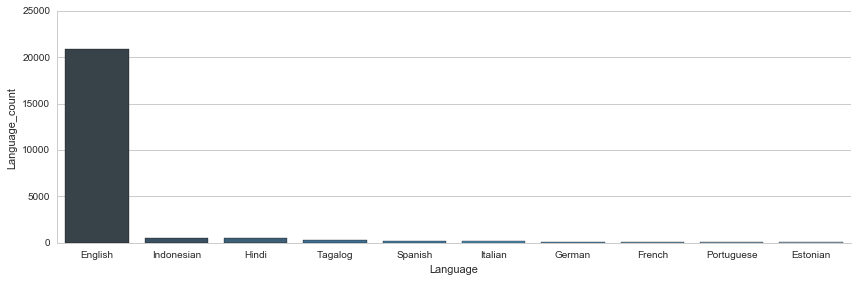

In [29]:
sns.factorplot(x='Language',y='Language_count',data=freq_df[:10],kind='bar',legend=True,orient="v",aspect=3,palette='Blues_d')

### Top 10 Popular hashtags

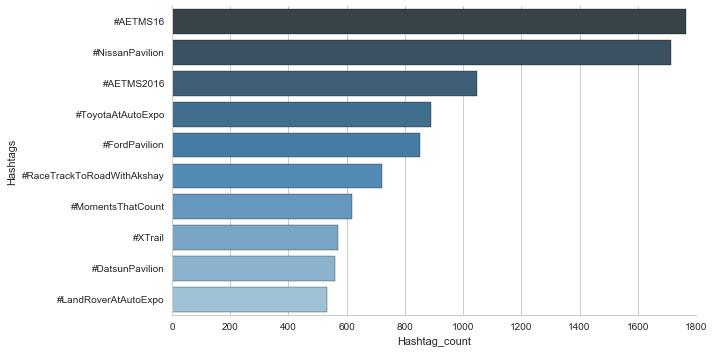

In [30]:
sns.factorplot(x='Hashtag_count',y='Hashtags',data=freq_df[1:11],kind='bar',legend=True,orient="h",size=5,aspect=2,palette='Blues_d')

### Top 10 Popular Mentions

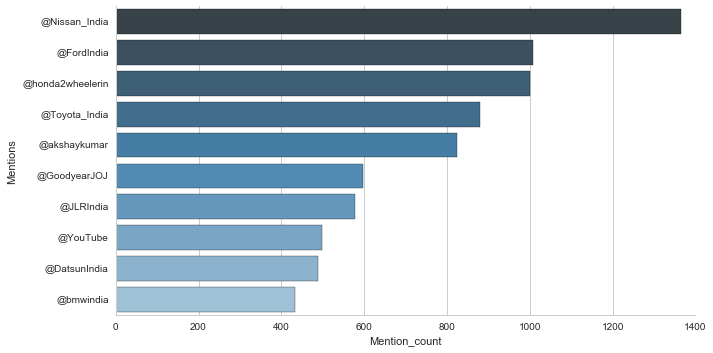

In [31]:
sns.factorplot(x='Mention_count',y='Mentions',data=freq_df[1:11],kind='bar',legend=True,orient="h",size=5,aspect=2,palette='Blues_d')

### Top 10 Popular Terms other than hastags and mentions

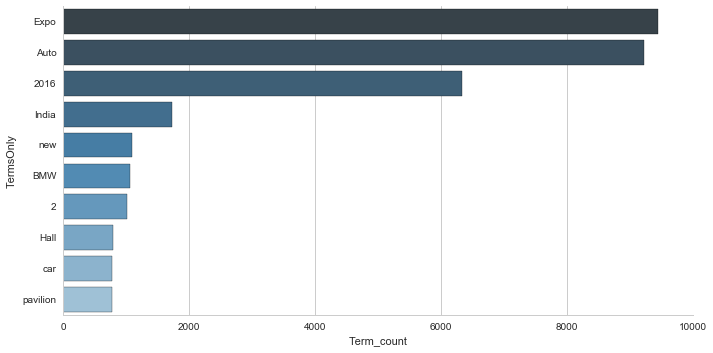

In [32]:
sns.factorplot(x='Term_count',y='TermsOnly',data=freq_df[:10],kind='bar',legend=True,orient="h",size=5,aspect=2,palette='Blues_d')

### Top 10 Users
### User who tweeted most regarding Auto Expo 2016

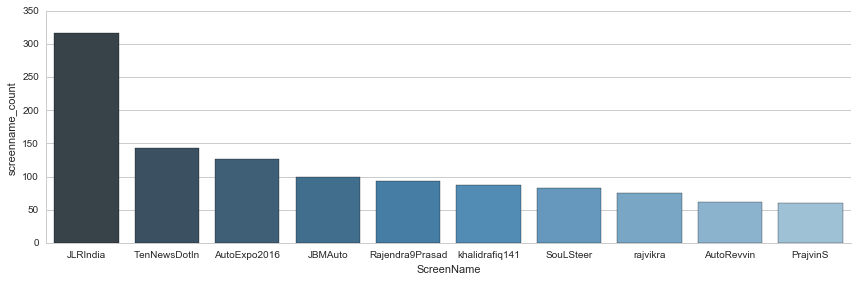

In [35]:
sns.factorplot(x='ScreenName',y='screenname_count',data=freq_df[:10],kind='bar',legend=True,orient="v",aspect=3,palette='Blues_d')

## Top Places from where Tweets Generated

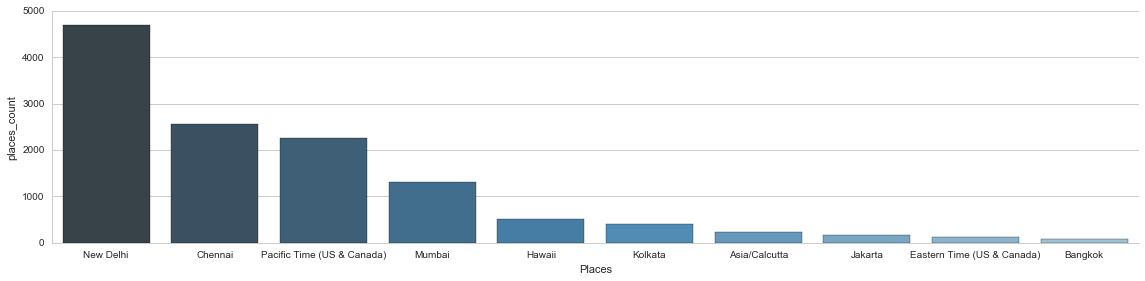

In [36]:
sns.factorplot(x='Places',y='places_count',data=freq_df[:10],kind='bar',legend=True,orient="v",aspect=4,palette='Blues_d')

# TimeSeries

### Includes the total number of tweets generated between (6th Feb to 8th Feb) in span of every 5 minutes

In [37]:
dates_autoexpo = []
f = open('tweets.json', 'r',encoding='utf-8')
for line in f:
    try:
        tweet = json.loads(line)
        dates_autoexpo.append(tweet['created_at'])
    except ValueError:
        continue
ones = [1]*len(dates_autoexpo)
idx = pd.DatetimeIndex(dates_autoexpo)
dates = Series(ones,index=idx)
per_minute = dates.resample('5Min', how='sum').fillna(0)
timeseries_df = DataFrame(per_minute)
timeseries_df.columns = ['total_freq']

In [38]:
#List of comapaies for tweet count
dates_ford = []
dates_nissan = []
dates_datsun = []
dates_maruti = []
dates_toyota = []
dates_jaguar = []
dates_tata = []
dates_bmw = []
dates_honda = []

#opening Tweets file
f = open('tweets.json','r')
for line in f:
    try:
        tweet = json.loads(line)
        terms = [term for term in preprocess(tweet['text'])]
        
        #appending dates for respective company name
        for s in terms:
            if re.search('ford',s.lower()):
                dates_ford.append(tweet['created_at'])
            if re.search('nissan',s.lower()):
                dates_nissan.append(tweet['created_at'])
            if re.search('datsun',s.lower()):
                dates_datsun.append(tweet['created_at'])
            if re.search('toyota',s.lower()):
                dates_toyota.append(tweet['created_at'])
            if re.search('maruti',s.lower()):
                dates_maruti.append(tweet['created_at'])
            if re.search('jaguar',s.lower()):
                dates_jaguar.append(tweet['created_at'])
            if re.search('bmw',s.lower()):
                dates_bmw.append(tweet['created_at'])
            if re.search('tata',s.lower()):
                dates_tata.append(tweet['created_at'])
            if re.search('honda',s.lower()):
                dates_honda.append(tweet['created_at'])
    except ValueError:
        continue
        
# a list of "1" to count the terms
ones_ford = [1]*len(dates_ford)
ones_nissan = [1]*len(dates_nissan)
ones_datsun = [1]*len(dates_datsun)
ones_toyota = [1]*len(dates_toyota)
ones_maruti = [1]*len(dates_maruti)
ones_jaguar = [1]*len(dates_jaguar)
ones_bmw = [1]*len(dates_bmw)
ones_tata = [1]*len(dates_tata)
ones_honda = [1]*len(dates_honda)


# setting date as index using DateTimeIndex
idx_ford = pd.DatetimeIndex(dates_ford)
idx_nissan = pd.DatetimeIndex(dates_nissan)
idx_datsun = pd.DatetimeIndex(dates_datsun)
idx_toyota = pd.DatetimeIndex(dates_toyota)
idx_maruti = pd.DatetimeIndex(dates_maruti)
idx_jaguar = pd.DatetimeIndex(dates_jaguar)
idx_bmw = pd.DatetimeIndex(dates_bmw)
idx_tata = pd.DatetimeIndex(dates_tata)
idx_honda = pd.DatetimeIndex(dates_honda)


# creating series for each maintained list
ford = Series(ones_ford, index=idx_ford)
nissan = Series(ones_nissan,index=idx_nissan)
datsun = Series(ones_datsun,index=idx_datsun)
toyota = Series(ones_toyota,index=idx_toyota)
maruti = Series(ones_maruti,index=idx_maruti)
jaguar = Series(ones_jaguar,index=idx_jaguar)
bmw = Series(ones_bmw,index=idx_bmw)
tata = Series(ones_tata,index=idx_tata)
honda = Series(ones_honda,index=idx_honda)

# Resampling Dates in 5minute bucket
per_minute_fo = ford.resample('5Min', how='sum').fillna(0)
per_minute_ni = nissan.resample('5Min', how='sum').fillna(0)
per_minute_da = datsun.resample('5Min', how='sum').fillna(0)
per_minute_to = toyota.resample('5Min', how='sum').fillna(0)
per_minute_ma = maruti.resample('5Min', how='sum').fillna(0)
per_minute_ja = jaguar.resample('5Min', how='sum').fillna(0)
per_minute_bm = bmw.resample('5Min', how='sum').fillna(0)
per_minute_ta = tata.resample('5Min', how='sum').fillna(0)
per_minute_ho = honda.resample('5Min', how='sum').fillna(0)

#dictionary for company wise collection of dates and thier respective counts
match_data = dict(FORD=per_minute_fo, NISSAN=per_minute_ni, DATSUN=per_minute_da,TOYOTA=per_minute_to,MARUTI=per_minute_ma,
                 JAGUAR=per_minute_ja,BMW=per_minute_bm,TATA=per_minute_ta,HONDA=per_minute_ho)

# dataframe of the above dictionary
all_matches = DataFrame(data=match_data,index=per_minute_fo.index)

# Resampling as above
all_matches = all_matches.resample('5Min', how='sum').fillna(0)

#timeseries_dataset = pd.concat([timeseries_df,all_matches],axis=1)

### 1. Timeseries for total tweets generated

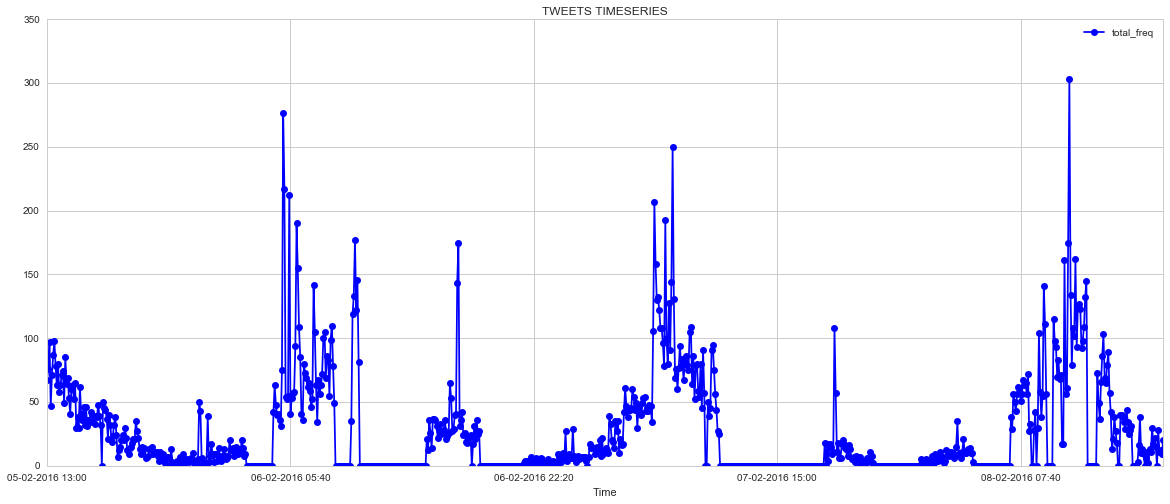

In [45]:
fig = timeseries_df.plot(timeseries_df.Time,'total_freq',figsize=(20,8),marker='o',linestyle='-',color='blue',title='TWEETS TIMESERIES')

### 2. Timeseries comparisonn between NISSAN,FORD and HONDA

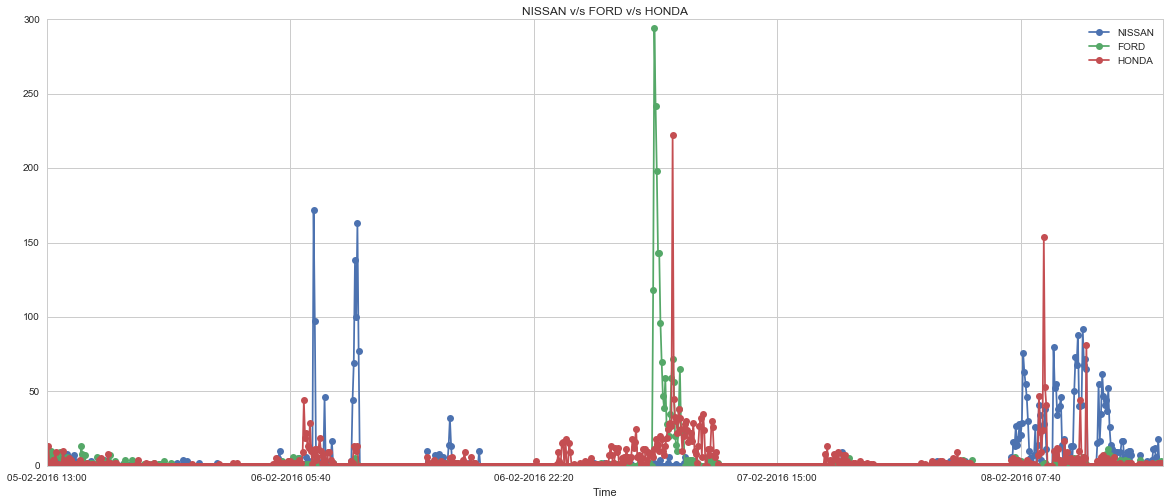

In [46]:
timeseries_df.plot(x=timeseries_df.Time,y=['NISSAN','FORD','HONDA'],marker='o',linestyle='-',figsize=(20,8),
                        title='NISSAN v/s FORD v/s HONDA')

### 2. Timeseries comparison for BMW,TOYOTA and DATSUN

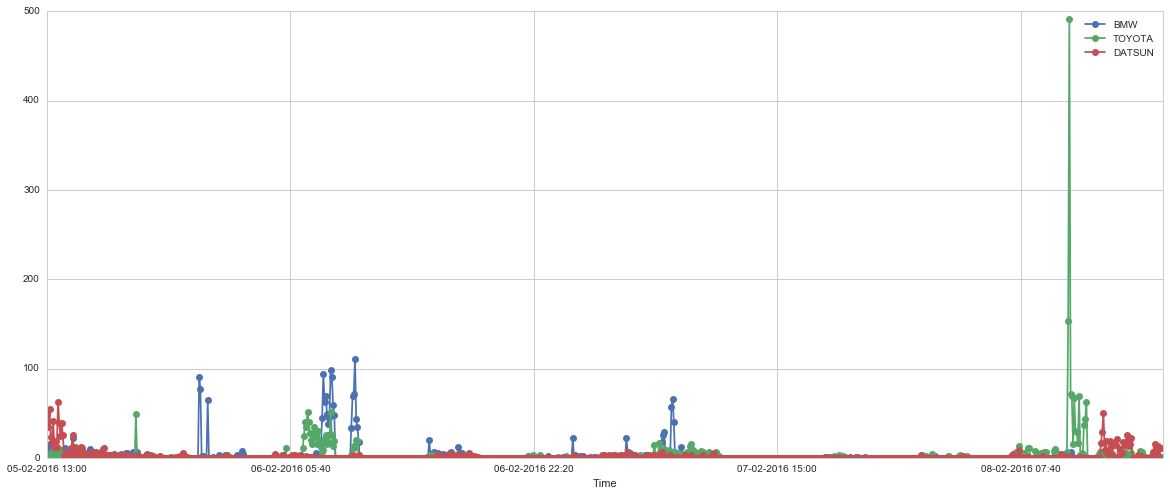

In [47]:
timeseries_df.plot(x=timeseries_df.Time,y=['BMW','TOYOTA','DATSUN'],marker='o',linestyle='-',figsize=(20,8))

# Multiclass Classification

In [49]:
#saving firts 5000 tweets in sample_df
sample_df = tweet_df[:5000]

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

#creating the Bag of Words
bow_transformer = CountVectorizer(analyzer=text_preprocess).fit(sample_df['text'])
print('Number of words : ' + str(len(bow_transformer.vocabulary_)))

Number of words : 4187


In [53]:
#creating a vector space i.e a sparse matrix of dimension number of tweets X number of words
tweet_bow = bow_transformer.transform(sample_df['text'])
print('Shape of Sparse Matrix: ', tweet_bow.shape)

Shape of Sparse Matrix:  (5000, 4187)


In [56]:
# calculating the Tf-Idf Score of bag of words
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(tweet_bow)
tweet_tfidf = tfidf_transformer.transform(tweet_bow)

In [57]:
#printing tf-idf score for a random words used
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Racing']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Maruti']])

6.52166089786
5.66724556971


In [58]:
#fitting a model on naive bayes multinominal
from sklearn.naive_bayes import MultinomialNB
auto_expo_model = MultinomialNB().fit(tweet_tfidf, sample_df['target'])

In [59]:
#taking a tweets from sample_df dataframe for predictio
sample_tweet = sample_df['text'][30]
print(sample_tweet)

Dream like big and Say YES to @DatsunIndia. Visit the #DatsunPavilion in #AutoExpo2016. 


In [60]:
#creating bag of words for sample tweet
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print(bow_sample.shape)

  (0, 565)	1
  (0, 1539)	1
  (0, 1854)	1
  (0, 1934)	1
  (0, 2170)	1
  (0, 3062)	1
(1, 4187)


In [62]:
#calculating tf-idf score for sample tweet
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 3062)	0.40017399828
  (0, 2170)	0.420975810301
  (0, 1934)	0.429822771582
  (0, 1854)	0.303074498094
  (0, 1539)	0.365157581124
  (0, 565)	0.502691070963


In [63]:
#generating a prediction in caomparision with the actual labelled tweet
print('predicted:', auto_expo_model.predict(tfidf_sample)[0])
print('expected:', sample_df.target[30])

predicted: Advertisement
expected: Advertisement


In [64]:
#creating a dataframe for the counts of manually labelled data
value_count_df = pd.DataFrame(Series(sample_df.target).value_counts())
value_count_df.columns = ['counts']
value_count_df.head()

,counts
Automobile,1740
Others,1694
Entertainment,615
Advertisement,473
Technology,327


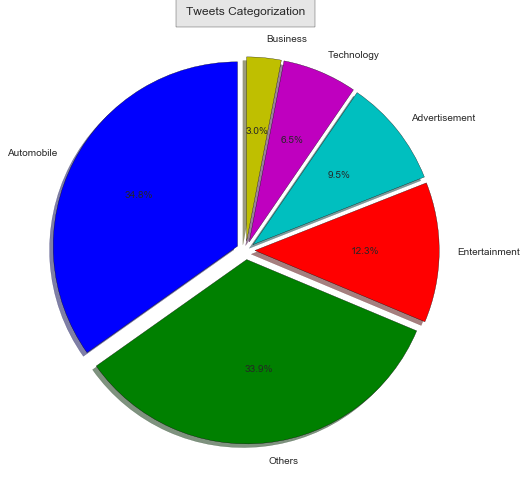

In [65]:
# make a square figure and axes
figure(1, figsize=(8,8))
ax = axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = value_count_df.index
fracs = value_count_df.counts
explode=(0.05, 0.05, 0.05,0.05,0.05,0.05)

pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90)

title('Tweets Categorization', bbox={'facecolor':'0.9', 'pad':10})

show()

## Naive Bayes Multinominal

In [69]:
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

#dividing the dataset into training and testing dataset
tweet_train, tweet_test, label_train, label_test = \
train_test_split(sample_df['text'], sample_df['target'], test_size=0.2)


print('Training Dataset : ',len(tweet_train),'\nTesting Dataset : ',len(tweet_test),'\nTotal Values : ',len(tweet_train) + len(tweet_test))

Training Dataset :  4000 
Testing Dataset :  1000 
Total Values :  5000


In [70]:
from sklearn.pipeline import Pipeline

#creating a pipeline to pass the tweets for the classification purpose
naive_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors with Naive Bayes classifier
])

In [72]:
#fitting a pipeline
naive_pipeline.fit(tweet_train,label_train)

#predicting the testing dataset
predictions_naive = naive_pipeline.predict(tweet_test)

#printing the classification report
print(classification_report(predictions_naive,label_test))

             precision    recall  f1-score   support

Advertisement       0.48      0.81      0.60        67
 Automobile       0.92      0.62      0.74       479
   Business       0.30      1.00      0.47        10
Entertainment       0.81      0.85      0.83       104
     Others       0.62      0.71      0.66       307
 Technology       0.45      0.94      0.61        33

avg / total       0.76      0.70      0.71      1000



In [93]:
#creating a naive bayes predictor
naive_predictor = naive_pipeline.predict(tweet_df[5001:]['text'])

#dataframe to counts all predictions
naive_df = pd.DataFrame(Series(naive_predictor).value_counts())
naive_df.columns = ['naive_counts']
naive_df

,naive_counts
Automobile,10384
Others,6760
Entertainment,1239
Advertisement,627
Technology,114
Business,12


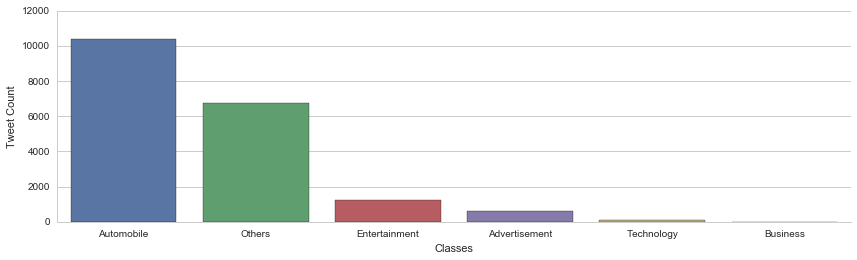

In [94]:
naive_graph = sns.factorplot(x=naive_df.index,y='naive_counts',data=naive_df,aspect=3,kind='bar')
naive_graph.set_axis_labels("Classes", "Tweet Count")

## Support Vector Machines

In [78]:
from sklearn.linear_model import SGDClassifier

#creating a SVM pipeline for the classification of tweets
svm_pipeline = Pipeline([('vect', CountVectorizer(analyzer = text_preprocess)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
 ])

In [79]:
#fitting pipeline on SVM
svm_pipeline.fit(tweet_train, label_train)

#predicting values on testing dataset based on SVM classifier
predictions_svm = svm_pipeline.predict(tweet_test)

#print the classification report
print(classification_report(predictions_svm,label_test))

             precision    recall  f1-score   support

Advertisement       0.58      0.82      0.68        80
 Automobile       0.91      0.82      0.86       359
   Business       0.48      0.94      0.64        17
Entertainment       0.81      0.84      0.82       104
     Others       0.84      0.78      0.81       383
 Technology       0.72      0.88      0.79        57

avg / total       0.83      0.81      0.81      1000



In [95]:
#predicting rest of the tweets with help of SVM classifier
svm_predictor = svm_pipeline.predict(tweet_df[5001:]['text'])

#dataframe to count all the predictions
svm_df = pd.DataFrame(Series(svm_predictor).value_counts())
svm_df.columns = ['svm_counts']
svm_df

,svm_counts
Others,8244
Automobile,6911
Advertisement,1776
Entertainment,1345
Technology,523
Business,337


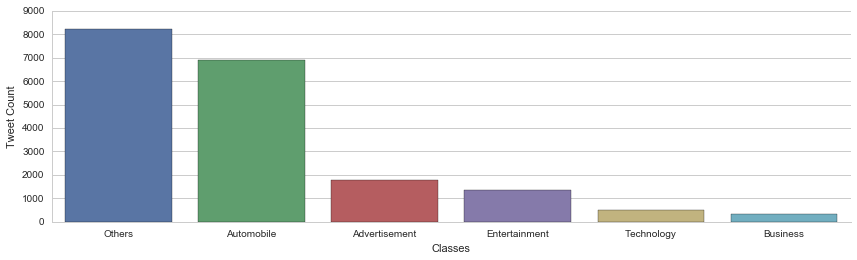

In [98]:
svm_graph = sns.factorplot(svm_df.index,y='svm_counts',data=svm_df,aspect=3,kind='bar')
svm_graph.set_axis_labels("Classes", "Tweet Count")

In [100]:
#creating a comparision dataframe for comparing the predictions of both algorithms
comparision_df = pd.concat([naive_df,svm_df],axis=1)
comparision_df

,naive_counts,svm_counts
Advertisement,627,1776
Automobile,10384,6911
Business,12,337
Entertainment,1239,1345
Others,6760,8244
Technology,114,523


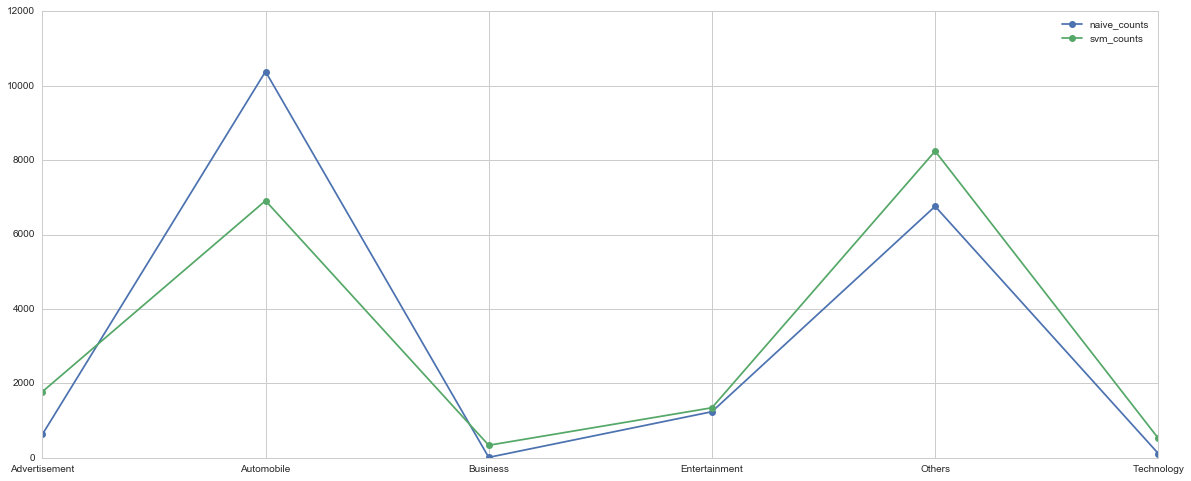

In [101]:
comparision_df.plot(x=comparision_df.index,y=['naive_counts','svm_counts'],marker='o',linestyle='-',figsize=(18,8),legend=True,label=['SVM'])